In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability, log_probability_2flares, log_probability_2flares2ars
from funcs.helper import calculate_inclination

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")


import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [2]:
R_jup*.92/R_sun 

<Quantity 0.09454167>

In [3]:
#tstamp = '13_12_2019_10_18'
tstamp

'06_03_2020_10_16'

In [4]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")

props = pd.read_csv(f"{CWD}/data/summary/properties.csv")

lcs = lcs.merge(props, left_on="ID", right_on="id")


lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[0]
i_mu, i_sigma = calculate_inclination(target)
i_mu, i_sigma = i_mu.to("rad").value, i_sigma.to("rad").value
target

ID                             100004076
QCS                                   14
typ                                  slc
cadence_min                            1
mission                              kep
prefix                               KIC
origin                           generic
h_mission                         Kepler
SpT                                   L1
view_start                        1356.5
view_stop                           1361
view_min                             600
view_max                            1050
BJDoff                           2454833
tstart                           1358.55
ampl_min                             NaN
ampl_max                             NaN
RA                                 286.7
Dec                              40.1857
J                                 13.078
R                                    NaN
Gaia_G                           17.8356
vsini_kms                           11.2
e_vsini_kms                          2.2
Prot_d          

In [5]:
i_sigma/np.pi*180

13.201291387460717

In [6]:
i_mu/np.pi*180

49.243391871664116

0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


KIC 100004076 modulation period:  8.880603057671022 h
Relative amplitude of modulation: -6.4e-03
[1337.16931409 1337.16999518 1337.17067637 ... 1371.33072079 1371.33140187
 1371.33208294]
[17.69224 17.69224 17.69224 ... 17.69224 17.69224 17.69224]


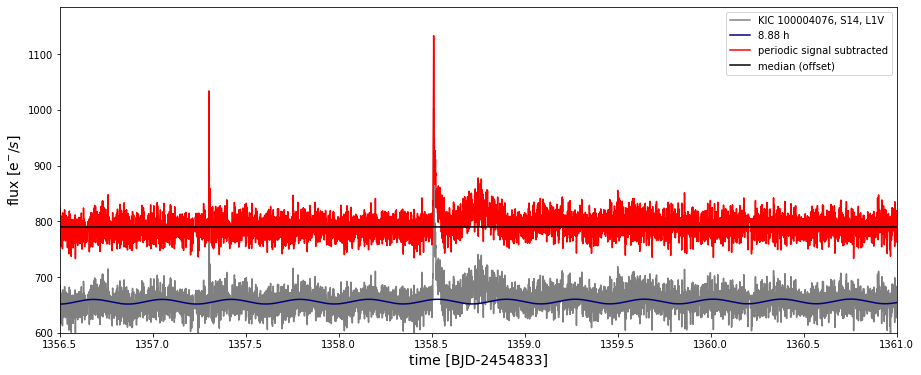

In [7]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
#from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False,)# cut=[target.view_start-5,target.view_stop+5])
print(t)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = F#refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                    # std_rolling_window_length=15, pad=25)

choice = (t > target.view_start +.5) & (t < target.view_stop-.25) # only one flare in TIC 237 : + 1.56 - 1.
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med)
phi = (t - t[0])/target.Prot_d * 2 * np.pi

In [11]:
len(phi)/900

6.088888888888889

(25, 30)

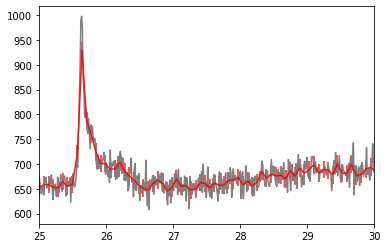

In [21]:
cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
plt.plot(cf.phi, cf.flux,color="grey")
plt.errorbar(cff.phi, cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
plt.xlim(25,30)

In [22]:
cff

,phi,flux,t,flux_err,median_
phi,,,,,
"(-0.0636, 0.0707]",0.034685,647.972537,1357.002446,17.692244,654.433146
"(0.0707, 0.141]",0.109835,656.261091,1357.006873,17.692244,654.433146
"(0.141, 0.212]",0.179204,650.164503,1357.010960,17.692244,654.433146
"(0.212, 0.283]",0.248573,645.769254,1357.015046,17.692244,654.433146
"(0.283, 0.354]",0.317943,650.991033,1357.019133,17.692244,654.433146
...,...,...,...,...,...
"(63.292, 63.363]",63.328026,652.448723,1360.731133,17.692244,654.433146
"(63.363, 63.434]",63.397396,646.173817,1360.735220,17.692244,654.433146
"(63.434, 63.505]",63.466765,652.383544,1360.739306,17.692244,654.433146


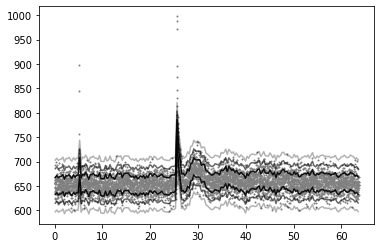

In [62]:

# cff = cf.groupby(pd.cut(cf.phi, 200))
# plt.scatter(cf.phi, cf.flux,color="grey",s=1)
# plt.plot(cff.phi.mean(), cff.flux.mean()+cff.flux_err.mean(),color="k", alpha=.9)
# plt.plot(cff.phi.mean(), cff.flux.mean()-cff.flux_err.mean(),color="k", alpha=.9)
# plt.plot(cff.phi.mean(), cff.flux.mean()+2*cff.flux_err.mean(),color="k", alpha=.6)
# plt.plot(cff.phi.mean(), cff.flux.mean()-2*cff.flux_err.mean(),color="k", alpha=.6)
# plt.plot(cff.phi.mean(), cff.flux.mean()+3*cff.flux_err.mean(),color="k", alpha=.3)
# plt.plot(cff.phi.mean(), cff.flux.mean()-3*cff.flux_err.mean(),color="k", alpha=.3)

In [36]:
cff.dropna(how="any").to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

654.4331461968876

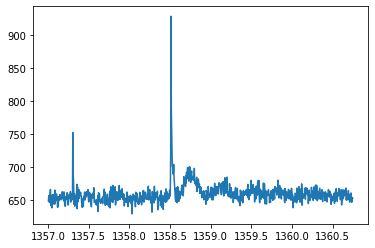

In [37]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(lc.t, lc.flux)

In [38]:
tstamp

'06_03_2020_10_16'

(600, 1250)

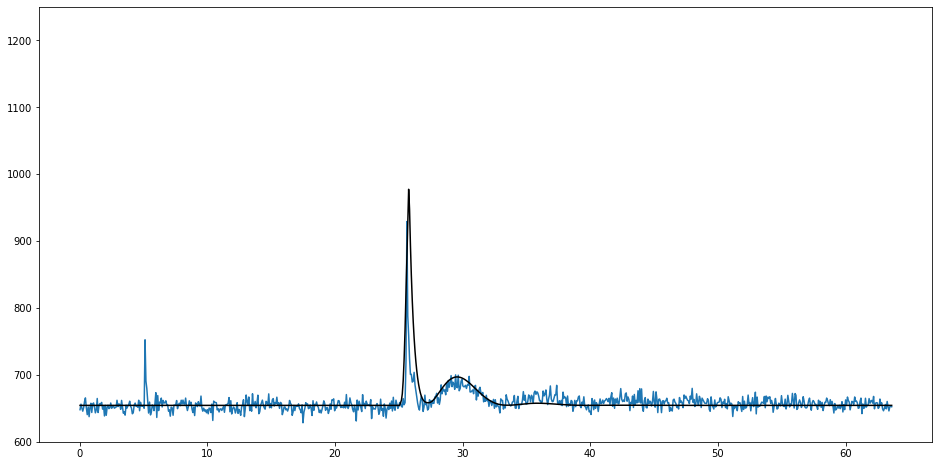

In [54]:

phi_a = 25.8
theta_a = 50*np.pi/180#target.theta_a_init
a = 1.2
fwhm =  .08/target.Prot_d * 2 * np.pi
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = -60* np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(phi,flux)
# for i in range(-180,180,10):
#     plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i* np.pi / 180,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(600,1250)

### Save inits

In [55]:
log_probs = {"log_probability":[6, log_probability],
             "log_probability_2flares":[9, log_probability_2flares],
             "log_probability_2flares2ars":[10, log_probability_2flares2ars],}

log_prob = "log_probability"
nparam = log_probs[log_prob][0]

with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)

## Run MCMC

In [ ]:
from funcs.flarefit import (log_probability,
                            log_probability_2flares,
                            log_probability_2flares2ars)

log_probs = {"log_probability":[6, log_probability],
             "log_probability_2flares":[9, log_probability_2flares],
             "log_probability_2flares2ars":[10, log_probability_2flares2ars],}






# Keyword arguments Nsteps = 50000

def run_mcmc(Nsteps=50000, wiggle=1e-3):

    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    target = inits.loc[inits.ID == ID,:]
    ndim = target.nparam
    nwalkers = 32


    inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
    pos = inits * (1. + wiggle * np.random.randn(nwalkers, target.nparam))

    # Set up the backend
    # Don't forget to clear it in case the file already exists
    filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)


    sampler = emcee.EnsembleSampler(nwalkers, target.nparam, log_probability,
                                    args=(phi, flux, flux_err, target.qlum,
                                          target.Fth, target.R_Rsun, target.median,
                                          {"i_mu":target.i_mu,
                                          "i_sigma":target.i_sigma}),
                                    backend=backend)

    sampler.run_mcmc(pos, Nsteps, progress=True, store=True);



if __name__ == "__main__":
# Read ID from keyboard here

# 

In [ ]:
from funcs.flarefit import log_probability
ndim = 6
nwalkers = 32


inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(nwalkers, ndim))

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma}),
                                backend=backend)

In [ ]:
print(f"MCMC run at {tstamp}\n\nlight curve file: {filename}")

## Resume MCMC after break

In [ ]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

In [ ]:
tstamp, target.ID

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(phi, flux, flux_err, 
                                          qlum, Fth, R, median, 
                                          {"i_mu":i_mu, "i_sigma":i_sigma, }),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))